In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import math
import time
import timeit

import sounddevice as sd
from scipy.io import wavfile

from multiprocess import Pool
import functools

In [31]:
sd.query_devices()
# sd.default.device = 3

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)
  2 ZoomAudioDevice, Core Audio (2 in, 2 out)

### Function to create file

In [32]:
def midi_to_timeseries(midiPath):
    """ Function that converts .txt file with midi events* to a list and returns all note on events.
    
    Args:
        midiPath: file path - .txt file with all note and pedal events of form [t,event,note/pedal,vel]
    
    Returns:
        time_notes: list of the form[[t,note,vel],[t,note,vel],[t,note,vel],...]
    
    """

    #    MIDI EVENT TYPES
    #    0x80 (hex)      128 (decimal)    Note Off
    #    0x90 (hex)      144 (decimal)    Note On
    #    0xB0 (hex)      176 (decimal)    Continuous Controller
    
    time_notes = []
    uniqueTypes = [128,144,176] 
            
    with open(midiPath) as midi_events:
        for line in midi_events:
            processedLine = line.split(" ")
    
            processedLine[0] = int(processedLine[0]) # processedLine[0] is timestamp
            processedLine[1] = int(processedLine[1], 16) # processedLine[1] is event type
            processedLine[2] = int(processedLine[2], 16) # processedLine[2] is note
            processedLine[3] = int(processedLine[3],16) # processedLine[3] is velocity

            if processedLine[1] not in uniqueTypes:
                print("unexpected event type got! ", processedLine[1])

            if processedLine[1] == 144:
                time_notes.append([processedLine[0], processedLine[2], processedLine[3]])
                
    return np.array(time_notes)

### Function to read .wav file

In [33]:
def read_audio(file):
    """ Function that reads .wav file of midi recording and saves it to a global variable
    Args:
        file: .txt file with midi notes
    """
    
    global samplerate, piano_audio
    samplerate, piano_audio = wavfile.read(file)

read_audio('Audio.wav')

/var/folders/f5/4s_l2s456y985n42_18zrt_00000gn/T/ipykernel_96849/2785934704.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, piano_audio = wavfile.read(file)


### Functions to deal with notes as integers vs names

In [34]:
def int_to_note(i):
    """ Function that converts note from integer to name
    Args:
        i: integer value corresponding to note
    Returns:
        note: note name, eg. "C4" 
    """
    
    # convert integer to note
    notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    return notes[i%12] + str(i//12 - 1)

def note_to_int(note):
    """ Function that converts note from name to integer
    Args:
        note: note name, eg. "C4"
    Returns:
        i: integer value corresponding to note
    """
    
    # convert integer to note
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    note = temp.match(note).groups()
    notes = {'C':0,'C#/Db':1,'C#':1,'Db':1,'D':2,'D#/Eb':3,'D#':3,'Eb':3,'E':4,'F':5,'F#/Gb':6,'F#':6,'Gb':6,'G':7,'G#/Ab':8,'Ab':8,'G#':8,'A':9,'A#/Bb':10,'A#':10,'Bb':10,'B':11}
    return notes[note[0]] + 12*(int(note[1])+1)


### Functions to help judge quality of match

In [35]:
def predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, curr_time,pred_time=100,sound=False):
    """ Function that predicts the next 100 ms given a match
    Args:
        notes: 
        source_id_start: 
        source_id_end: 
        target_id_start: 
        target_id_end: 
        curr_time: 
        
    Returns:
        pred: predicted notes for 100ms, [[predTime1, note1, vel1], [predTime2, note2, vel2],...]
    """
    
    # predicting pred_time(100ms) of music
    time_ratio = (notes[target_id_start][0]-notes[target_id_end][0])/(notes[source_id_start][0]-notes[source_id_end][0])
    last_matching_note_target=0
    for event1 in range(source_id_start,source_id_end,-1):
        for event2 in range(target_id_start,target_id_end,-1):
            s = note_similarity(notes[event1],notes[event2],time_ratio)
            if s > 0:
                last_matching_note_target = event2
                break
        if last_matching_note_target:
            break
    
    target_time = notes[last_matching_note_target][0]
    time = target_time
    predicted = [target_id_start]
    i = target_id_start + 10
    while time <= target_time + pred_time:
        if notes[i][0] < time:
            predicted.append(i)
            i += 1
        time += 10
    predicted.append(i)
    
        
    if(sound):
        play_match(notes[source_id_start][0],notes[source_id_end][0],notes[predicted[-1]][0],notes[predicted[0]][0],pausebetween=False)
        
    return predicted
    
def display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, sourceStart, targetStart):
    """ Function that displays the snippets if they match.
    Args:
        notes: note name, eg. "C4"
        source_start: 
        source_end: 
        target_start: 
        target_end: 
        score: 
        sourceStart: 
        targetStart: 
    """
    
    print("Score: ", score)
    print("Source({st}):  Target({tt}): ".format(st=source_id_end, tt=target_id_end))
    for i in range(min(source_id_start-source_id_end, target_id_start-target_id_end)):
        print(notes[i+source_id_end][0]-sourceStart, int_to_note(notes[i+source_id_end][1]), end=", ")
        print(notes[i+target_id_end][0]-targetStart, int_to_note(notes[i+target_id_end][1]))
    for i in range(target_id_start-target_id_end, source_id_start-source_id_end):
        print(notes[i+source_id_end][0]-sourceStart, int_to_note(notes[i+source_id_end][1]), end=", \n")
    for i in range(source_id_start-source_id_end, target_id_start-target_id_end):
        print("        ,",notes[i+target_id_end][0]-targetStart, int_to_note(notes[i+target_id_end][1]))
        
    print("  Next notes: ")
    for i in range(5):
        print(notes[i+source_id_start][0]-sourceStart,int_to_note(notes[i+source_id_start][1]), end=", ")
        print(notes[i+target_id_start][0]-targetStart,int_to_note(notes[i+target_id_start][1]))
        
    print()
        
def play_match(source_start, source_end, target_start, target_end, pausebetween=False):
    """ Function that plays portion of audio file corresponding to each sequence of a match
    Args:
        source_start: 
        source_end: 
        target_start: 
        target_end: 
    """
    
    global piano_audio
    ss = source_start * samplerate // 1000
    se = source_end * samplerate // 1000
    te = target_end * samplerate // 1000
    ts = target_start * samplerate // 1000
    #Source
    sd.play(piano_audio[se:ss], samplerate, blocking = True)
    if pausebetween:
        time.sleep(1)
    #Target
    sd.play(piano_audio[te:ts], samplerate, blocking = True)
    if pausebetween:
        time.sleep(1)
        
def display_snippet_plot(notes, source_start, source_end, target_start, target_end, score, sourceStart, targetStart):
    plt.figure(figsize = (10,5))
    lenSource = source_start-source_end
    lenTarget = target_start-target_end
    timeStampSourceEnd = notes[(lenSource - 1)+source_end][0]-sourceStart
    timeStampTargetEnd = notes[(lenTarget - 1)+target_end][0]-targetStart

    if timeStampSourceEnd >= timeStampTargetEnd:
        xmax = timeStampSourceEnd
    else:
        xmax = timeStampTargetEnd

#     plt.xlim(0,xmax)
    plt.xlabel("Relative Snippet Time (in MS)")
    # yscale = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    # plt.yticks(range(0,len(yscale)),yscale)
    plt.ylabel("Note (Integer Representation)")
    title = "Snippet Plot:" + ", Source @ " + str(notes[source_end][0]) + " ms, Target @ " + str(notes[target_end][0]) + " ms, Score: " + str(round(score,4))
    plt.title(title)
    plt.locator_params(axis="both", integer=True, tight=True)

    sourceX = []
    sourceY = []
    targetX = []
    targetY = []
    for i in range(min(source_start-source_end, target_start-target_end)):
        sourceX.append(notes[i+source_end][0]-sourceStart)
        sourceY.append((notes[i+source_end][1]))
        targetX.append(notes[i+target_end][0]-targetStart)
        targetY.append((notes[i+target_end][1]))
    for i in range(target_start-target_end, source_start-source_end):
        sourceX.append(notes[i+source_end][0]-sourceStart)
        sourceY.append((notes[i+source_end][1]))
    for i in range(source_start-source_end, target_start-target_end):
        targetX.append(notes[i+target_end][0]-targetStart)
        targetY.append((notes[i+target_end][1]))

    plt.scatter(sourceX, sourceY, label="Source",marker='*')
    plt.scatter(targetX, targetY, label="Target",marker='.')
    plt.legend()
    plt.show()

def display_snippet_plot_2(sequence1,sequence2,source_start,target_start,score, time_ratio):
    plt.figure(figsize = (10,5))

#     plt.xlim(0,xmax)
    plt.xlabel("Relative Snippet Time (in MS)")
    # yscale = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    # plt.yticks(range(0,len(yscale)),yscale)
    plt.ylabel("Note (Integer Representation)")
    plt.locator_params(axis="both", integer=True, tight=True)

    sourceX = [] # x axis - source timestamp in ms
    sourceY = [] # y axis - note integer repr for source
    targetX = []
    targetY = []
    for i in range(len(sequence1)):
        sourceX.append(sequence1[i][0]*time_ratio)
        sourceY.append(sequence1[i][1])

    for i in range(len(sequence2)):
        targetX.append(sequence2[i][0])
        targetY.append(sequence2[i][1])

    title = "Snippet Plot:" + ", Source @ " + str(source_start) + " ms, Target @ " + \
        str(target_start) + " ms, Score: " + str(score) + ", Length (ms): "+ str(sourceX[-1]-sourceX[0])
    plt.title(title)
    plt.scatter(sourceX, sourceY, label="Source",marker='*')
    plt.scatter(targetX, targetY, label="Target",marker='.')
    plt.legend()
    plt.show()
    
    
    

### Functions to calculate similarity

In [96]:
def two_way_similarity(tf1, tf2, disp = False):
    a1,b1,score1 = musical_similarity(tf1,tf2,disp)
    b2,a2,score2 = musical_similarity(tf2,tf1,disp)
    if score1>score2:
        return a1,b1,score1
    return a2,b2,score2

def musical_similarity(tf1, tf2, disp = False):
    """ Function that calculates similarity score between 2 snippets 
        eg [[-17,60],[-100,62],[-101,64],[-300,60]] and [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]
    
    Args:
        tf1: first snippet [[t,note],[t,note],[t,note],...]
        tf2: second snippet [[t,note],[t,note],[t,note],...]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    tf1 = np.array(tf1)
    tf2 = np.array(tf2)
    
    # updating time stamps wrt first note for tf1
    sequence1 = tf1
    sequence1[:,0] = tf1[:,0]-tf1[0,0]
    
    # updating time stamps wrt first note for tf2
    ind = np.argwhere(tf2[:,1] == tf1[0,1])
    if ind.any():
        ind = ind[0]
    else:
        ind = 0
    sequence2 = tf2
    sequence2[:,0] = tf2[:,0]-tf2[ind,0]
    
    seq_1_time_del = (tf1[-1][0] - tf1[0][0]) * 1.0
    seq_2_time_del = tf2[-1][0] - tf2[0][0]
    
    time_ratio = seq_2_time_del / seq_1_time_del
    
    # Calculating score array by comparing every note from each sequence and taking the best match
    scores = note_similarity_vect(sequence1,sequence2,time_ratio)
    score = scores.max(axis=0)
    score2 = scores.max(axis=1)
    lastmatch1, = np.nonzero(score)
    if lastmatch1.any():
        lastmatch1 = lastmatch1[-1]
    else:
        lastmatch1 = -1
    lastmatch2, = np.nonzero(score2)
    if lastmatch2.any():
        lastmatch2 = lastmatch2[-1]
    else:
        lastmatch2 = -1
    
    # For every pair of notes in both sequences, if a match was not found, add a zero score
    count_zeros = np.sum(score==0)
    count_score = sequence1.shape[0] + sequence2.shape[0] + count_zeros - score.shape[0]
  
    # Similarity of the two sequences is the mean of the note similarity scores
    score_1 = np.sum(score)/(count_score)
    
    # including length in score, if at least 5 notes
    if len(tf1)>5:
        score_1 += score_1 * seq_1_time_del/500000 # 50 seconds yield 10% increase
    
    if disp and score_1>0.7:
        print("Scores:",score)
        print("Sequence1: ",sequence1)
        print("Sequence2: ",sequence2)
#         print("Matched vals: ",matched_targets)
        display_snippet_plot_2(sequence1,np.array(sequence2),tf1[0][0],tf2[0][0],score_1, time_ratio)
    
#     return score_1
    return lastmatch1, lastmatch2, score_1


def note_similarity_vect(sequence1,sequence2,ratio=1):
    """ Function that calculates similarity score between 2 notes - depending on note value and time.
        The score is linear with time difference between notes.
    
    Args:
        note1: first note to compare [t,note,vel]
        note2: second note to compare [t,note,vel]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    
    minmin_dist = 30
    min_dist = 100 #+ 40 * max(ratio,1/ratio) # acceptable time difference for same note

    time_diff = abs(sequence1[None,:,0] * ratio - sequence2[:,None,0])
    op = (sequence1[None,:,1] == sequence2[:,None,1]) * (time_diff < min_dist) * ((time_diff <= minmin_dist) + (time_diff > minmin_dist) * (1 - (time_diff-50)/min_dist))
    
    return op
    
# def note_similarity_vect_v2(sequence1,sequence2,ratio=1):
#     """ Function that calculates similarity score between 2 notes - depending on note value and time.
#         The score is linear with time difference between notes.
    
#     Args:
#         note1: first note to compare [t,note,vel]
#         note2: second note to compare [t,note,vel]
    
#     Returns:
#         score: similarity - integer between 0 to 1
    
#     """
    
#     minmin_dist = 30
#     min_dist = 50 * ratio # acceptable time difference for same note

#     time_diff = abs(sequence1[None,:,0] * ratio - sequence2[:,None,0])
#     op = (sequence1[None,:,1] == sequence2[:,None,1]) * (time_diff < min_dist) * (1 - (time_diff/min_dist))
    
#     return op
    

### Helper Functions

In [37]:
def time_to_index(notes, timestamp):
    for i in range(len(notes)):
        if notes[i][0] > timestamp:
            return i
        
def index_to_time(notes, index):
    return notes[index][0]

def index_to_sequence(notes, ids): # assume start>end & not include start for convention
    start_id, end_id = ids
    sequence = []
    for i in range(end_id,start_id):
        sequence.appaned(notes[i])
    return sequence

def time_to_sequence(notes, times): # assume start>end & not include start for convention
    start, end = times
    i = time_to_index(notes, end)
    sequence = []
    while i < len(notes):
        if notes[i][0]>=start:
            break
        sequence.append(notes[i])
        i += 1
    return sequence


In [38]:
midiPath = '../midi-recordings/ladispute.txt'
# midiPath = '../midi-recordings/2_prelude.txt'
notes = midi_to_timeseries(midiPath)

0.9820077921431538
0.21656950039501827
0.12433575789041602
0.20825461444740848
0.14783862658474883
0.09722332366337345
0.14243152860949213
0.1315484102030361
0.11155207976145168
0.11547259345472867
0.09321079892084815
0.09428767234806597
0.08012006660938138
0.0895033062203495
0.09002390463907774
0.07896170297793341
0.0773626576191946
0.07127040585871355
0.06722262334088745
0.07899863543328633
0.07213056583794508
0.07622408319943447
0.07741055176054122
0.2187753034695046
0.20607160712698566
0.12886979534995133
0.16966190901293363
0.12089621634771475
0.09831890885062061
0.11573162748755605
0.12153487872680821
0.11603522400129002
0.10534135462094611
0.0920228022203142
0.08527504549450549
0.07680697833012595
0.08409766782577613
0.07584457646529096
0.07488486725059688
0.07811879528007283
0.07470219488173267
0.07844717325268381
0.07077638612633133
0.06607751351617672
0.06792829157271002
0.06417806142159758
0.4637832482282106
0.1444232690964966
0.11162022183767654
0.10421602332547301
0.108746

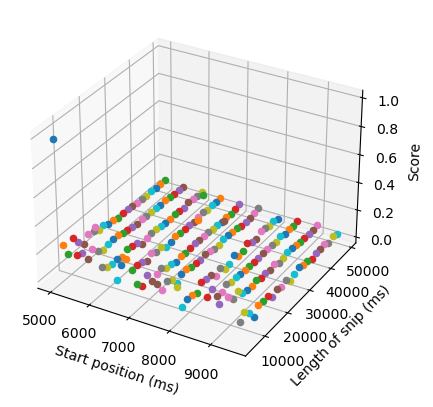

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# matches=[]
for x in range(5000,10000,500):
#     print(x)
#     x = 0
    for y in range(5000,50000,2000):
        t1 = [y+x,0+x] # timestamps in ms
#         t2 = [191400+y+x,191400+x]
        t2 = [413000+y+x,413000+x]
#         t2 = [587000+y+x,587000+x]

        tf1 = time_to_sequence(notes, t1)
        tf2 = time_to_sequence(notes, t2)

#         a,b,score = musical_similarity(tf1,tf2,True)
        a,b,score = two_way_similarity(tf1,tf2,False)
        print(score)
#         matches.append([x,y,score])
        ax.scatter(x,y,score)
#         if score<0.8:
#             display_snippet_plot(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
    #         play_match(t1[0],t1[1],t2[0],t2[1])
    #         predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)
    #         time.sleep(2)
#             break
#     break

# plt.scatter3D(matches)
ax.set_xlabel('Start position (ms)')
ax.set_ylabel('Length of snip (ms)')
ax.set_zlabel('Score')
plt.show()

In [77]:
def calculate_similarity_time(notes, source_id, currTime, max_matches=None, skip = 100, disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        max_matches: optional param to state how many matches to stop after
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    calcstart = timeit.default_timer()
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds
#     count = 0 # counting num "good" matches
    
    target_start = length_ms
    while target_start < currTime-5000:
#     for target_start in range(currTime-5000, currTime-1000, skip):
#         starttime = timeit.default_timer()
        target_end = target_start - length_ms # pick target_end by time length of course snip
        
        # finding new end index
        for i in range(last_id_end,len(notes)):
            if notes[i][0] >= target_end:
                target_id_end = i
                break
             
        # finding new start index
        for i in range(target_id_end,len(notes)):
            if notes[i][0] > target_start:
                target_id_start = i
                break
                
        if target_id_end > target_id_start-4:
            last_id_end = target_id_end
            last_id_start = target_id_start
            target_start += skip
            continue
        if target_id_end == last_id_end and last_id_start == target_id_start:
            target_start += skip
            continue
            
#         lm1,lm2,score = musical_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],disp=disp)
        lm1,lm2,score = two_way_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],disp=disp)
        
        if score:
            if score>0.7:
#                 count += 1
                # Dsiplaying matches > 0.7 if disp is True
                if disp:
                    display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
#                     display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                    play_match(currTime, source_end, target_start, target_end)
#                     predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)
                    time.sleep(5)

            if score>0.5:
                target_time = target_start
                # case 1
                if lm1 >= source_id_start - source_id_end - 2:
                    target_time = notes[target_id_end+lm2][0]
#                     print(target_id_end+lm2,target_time)
                # case 2 - run again with target slightly ahead?
                elif lm2 >= target_id_start - target_id_end - 2 and currTime - notes[source_id_end+lm1][0] > 0:
                    target_start += currTime - notes[source_id_end+lm1][0]
                    continue
                matches.append([currTime, target_time, score])
        
        last_id_end = target_id_end
        last_id_start = target_id_start
        target_start += skip
        
#         if max_matches and count > max_matches:
#             break

#         looptime = timeit.default_timer() - starttime
#         if looptime>0.05:
#             print("LoopTime:",looptime,"target&source:",currTime,target_start)
        
    calctime = timeit.default_timer() - calcstart
    global t_exec
    t_exec[currTime]=calctime
#     if calctime>1:
#         print("Time:",calctime,"for source:",currTime,"and length",length_ms,"ms",",score:",matches[:][2])
    
    return matches


In [78]:
def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        snips: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)
        offset: used to find note snippets longer than min_length, integer, default=0
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    start_index = np.argwhere(notes[:,0] > start_time)
    if start_index.any():
        start_index = start_index[0]
    else:
        print("Error: Start time too large")
        return np.array([None,None])
    
    if start_index<min_notes:
        return np.array([None,None])
    
    end_index = np.arange(start_index-min_notes, start_index - max_notes - 1, -1)
    ids = (start_time - notes[end_index,0] >= min_time) * end_index
    ids = ids[np.nonzero(ids)]
    if ids.any():
        source_id = np.array([start_index[0],ids[0]])
        return source_id
        
#     print("Error: Trying to access snippet length > max_notes",end=" ")
    return np.array([None,None])

In [79]:
def find_matches_at_timestamp(i, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp):
    """Function that finds similarity from lengths minNotes to maxNotes ...
    
    Args:
    
    Returns:
    
    """
    sims_arr = []
    print("\r",end="")
    print("i:",i,end="   ")
    # only calculate on historical timestamps
    offset = 500
#     count = notes[-1,0] + 1 # count number of relevant matches
    numSourceNotes = 0
    sourceTime = 0
#     attempt = 1
#     while numSourceNotes < maxNotes:
    while sourceTime < maxTime:
        sourceId = get_source_notes(notes, i, minNotes, maxNotes, sourceTime+offset)
        if not sourceId.any():
#             print("Failed for source_id = ", sourceId, ", on attempt ", attempt,end=" ")
#             if offset>0:
#                 percentage_matches_any += 1
            break

        # num notes in source snippet
        numSourceNotes = (sourceId[0] - sourceId[1])
        # total time in ms in source snippet
        sourceTime = i - notes[sourceId[1]][0]
        
        sim = calculate_similarity_time(notes, sourceId, i, disp=disp)
        for match in sim:
            match.append(numSourceNotes)
            match.append(sourceTime)
        sims_arr.extend(sim)
#         sim = np.array(sim)
#         count = np.sum(np.nonzero(sim[:,2] > thresh)[0])
        offset += 500
#         attempt += 1

#     print(sims_arr)
    return np.array(sims_arr)

In [97]:
midiPath = '../midi-recordings/ladispute.txt'
# midiPath = '../midi-recordings/2_prelude.txt'
notes = midi_to_timeseries(midiPath)

global t_exec

minNotes = 8
maxNotes = 150 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 25000
skip = minTime
end = notes[-1][0]
thresh = 0.9
t_exec = np.zeros(notes[-1][0])

# calculating similarity
sims_arr = []
curr_times = np.arange(start, end, minTime)
# fmt = np.vectorize(find_matches_at_timestamp,signature="(),"+str(notes.shape)+",(),(),(),(),(),()") #,signature="(2),(2),()->()", otypes=[np.float]
# sims_arr = fmt(curr_times, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp=False)

fm = functools.partial(find_matches_at_timestamp, notes=notes, minNotes=minNotes, minTime=minTime, maxNotes=maxNotes, maxTime=maxTime, thresh=thresh, disp=False)

# for i in curr_times:
%prun sims_arr.extend(find_matches_at_timestamp(25000, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp=False))


i: 25000    

In [98]:
fm(25000)

with Pool(8) as p:
    sims_arr = p.map(fm, curr_times)

i:050000   i:i:i: 25000 i:   70000i:   92500  115000   i: 137500    160000   182500       26500    28000    49000    29500    31000    32500i: 71500    50500    34000    94000    35500    52000    37000    73000    116500    38500    53500    40000    161500    55000    139000    41500    95500   i:i: 43000    74500    56500    44500    184000    58000i: 46000    118000    76000    97000    205000    59500    163000    77500    140500    61000    119500    98500    62500    79000    206500    64000    164500    80500    100000    185500   i:i: 65500    142000    121000    82000    67000    101500    208000    68500    83500i: 166000    122500    143500    227500    103000    187000    85000    209500    86500    104500    167500    124000    145000    88000    106000    188500    125500    89500    211000    169000    229000    107500    146500    91000    127000    190000    109000   i:i:  250000170500       212500    148000    128500    110500    191500    230500    172000    112000 

In [99]:
## choosing only significant scores and storing the new data in sims_plot

s = []
for i in range(len(sims_arr)):
    s.extend(sims_arr[i])
    
s = np.array(s)
sims_thresh = s * (s>thresh) # considering a match if score greater than a threshold

simsDF = pd.DataFrame(data=sims_thresh, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])
simsDFall = pd.DataFrame(data=s, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])


<AxesSubplot:title={'center':'All matches >0.9, for \nMin Notes=8 notes, Max Notes=150'}, xlabel='source_timestamp', ylabel='target_timestamp'>

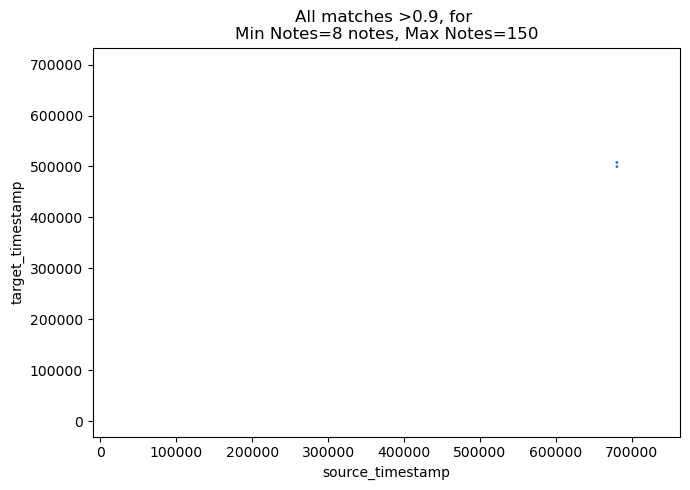

In [100]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)




Percentage matches found: 54.46808510638298%


Percentage matches >0.9 found: 0.2127659574468085%


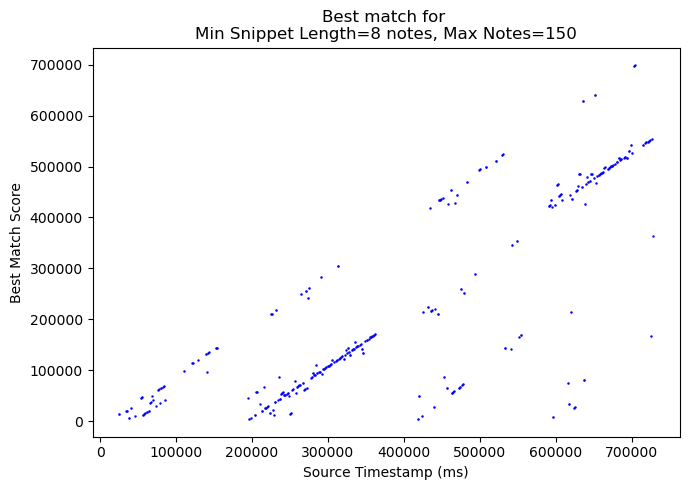

In [101]:
# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

total = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if simsDFall['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
    else:
#         print("No match for",x)
        continue
    plt.scatter(simsDFall['source_timestamp'].loc[y],simsDFall['target_timestamp'].loc[y],simsDFall['score'].loc[y],c='blue')
   
# gjnjn
percentage_matches_any /= total
percentage_matches_thresh /= total
print("\n\nPercentage matches found: ", percentage_matches_any*100,"%",sep="")
print("\n\nPercentage matches >",thresh," found: ", percentage_matches_thresh*100,"%",sep="")

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.show()

214


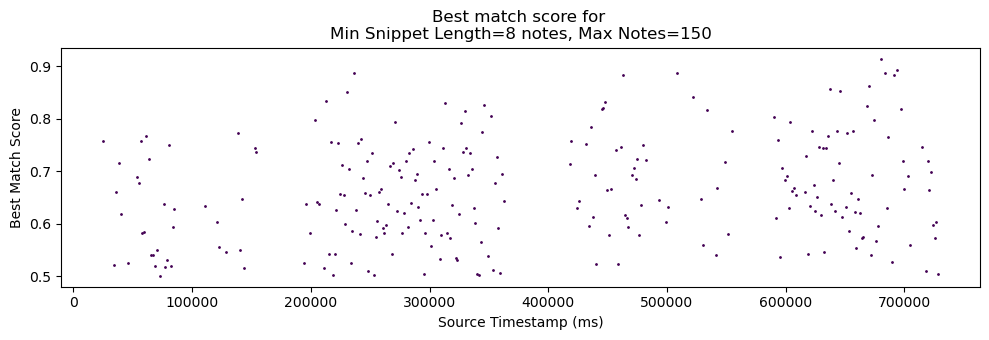

In [102]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,y,1,c=s,cmap='viridis') # need to include s (len of best match)
    
print(count)
plt.title("Best match score for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.show()

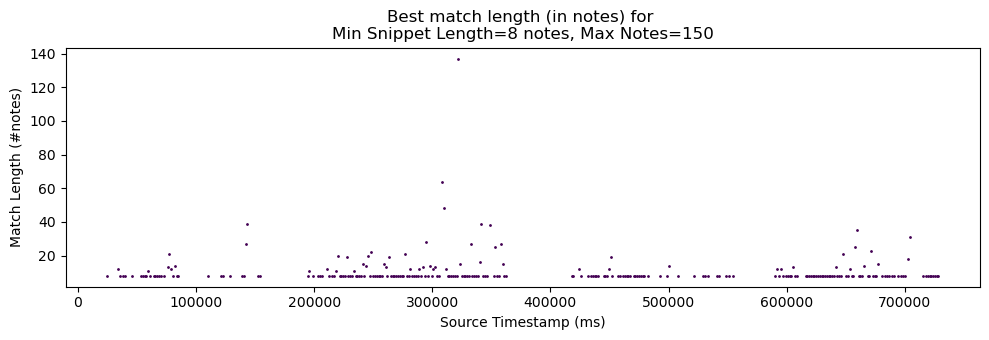

In [103]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
plt.title("Best match length (in notes) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (#notes)")
plt.show()

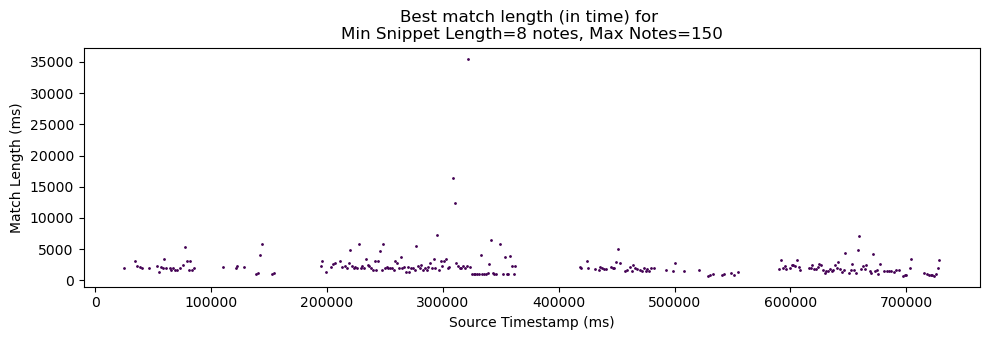

In [104]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
plt.title("Best match length (in time) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (ms)")
plt.show()

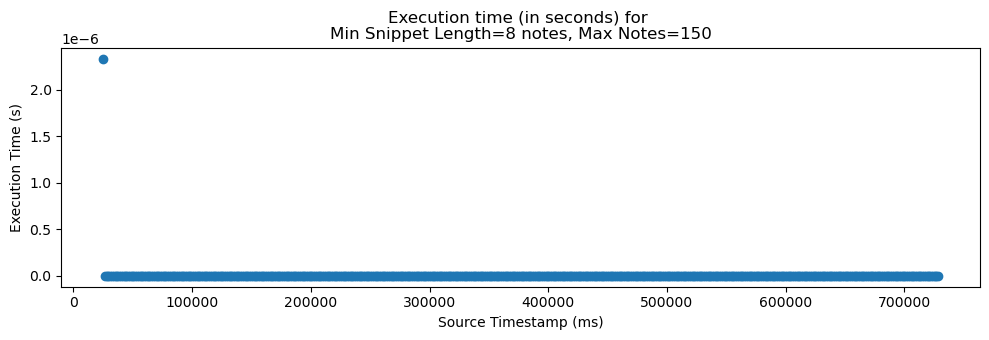

In [105]:
plt.scatter(curr_times,t_exec[curr_times])
# plt.scatter(range(len(t_exec)),t_exec)
plt.title("Execution time (in seconds) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Execution Time (s)")
plt.show()